* load lightning module from checkpoints
* eval models with various decision score on metrics
* visualisation sample

In [1]:
import hydra
from src.commons.constants import PROJECT_PATH
from omegaconf import DictConfig, OmegaConf

import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence

from src.commons.utils_io import load_sam, make_path
from src.commons.utils import *
from src.models.commons.mask_process import extract_object_from_batch, binarize_mask
from src.commons.constants import *
from src.data.process import generate_grid_prompt
from src.models.magic_pen.task import MagicPenModule

In [2]:
from pathlib import Path

d = "/jo/djei/lm.com"
str(Path(d).parent)

'/jo/djei'

In [3]:
import pandas as pd
d = pd.Series([1, 2], name="a")

next(iter(d))

1

### Load config from run

Inside a Lightning checkpoint you’ll find:

* 16-bit scaling factor (if using 16-bit precision training)
* Current epoch
* Global step
* LightningModule’s state_dict
* State of all optimizers
* State of all learning rate schedulers
* State of all callbacks (for stateful callbacks)
* State of datamodule (for stateful datamodules)
* The hyperparameters (init arguments) with which the model was created
* The hyperparameters (init arguments) with which the datamodule was created 
* State of Loops

In [4]:
def _cfg():
    """generate register items - to be updated"""
    pass


_register_runs_ckpt = {
    "test":{
        "baseline": make_path(
            "2024-08-11_10-22-42/checkpoints/epoch_002.ckpt",
            "../logs/old/test_loss/levir-cd/vit-b",
            )
    },
    "probing_concat":{
        "baseline": make_path(
            "2024-08-02_18-31-45/checkpoints/epoch_099.ckpt", 
            LOGS_PATH, 
            "beta",
            "beta_probing/levir-cd/vit-b"
        )
    }
}

_register_runs_params = {
    "test":{
        "baseline": make_path(
            "2024-08-11_10-22-42/.hydra/config.yaml",
            "../logs/old/test_loss/levir-cd/vit-b",
            )
    },
    "probing_concat":{
    "baseline": make_path(
        "2024-08-02_18-31-45/.hydra/config.yaml",
        LOGS_PATH, 
        "beta",
        "beta_probing/levir-cd/vit-b"
        )
    }
}

In [5]:
_register_runs_params.keys()

dict_keys(['test', 'probing_concat'])

In [6]:
# model_type = "probing_concat"
# model_name = "baseline"
model_type = "test"
model_name = "baseline"

In [7]:
_register_runs_params[model_type][model_name]

'../logs/old/test_loss/levir-cd/vit-b/2024-08-11_10-22-42/.hydra/config.yaml'

In [8]:
def load_ckpt_cfg(model_type, model_name):
    return OmegaConf.load(_register_runs_params[model_type][model_name])


def load_params_module(cfg):
    model = hydra.utils.instantiate(cfg.model.instance.network)
    optimizer = hydra.utils.instantiate(cfg.model.optimizer)
    scheduler = hydra.utils.instantiate(cfg.model.scheduler)
    loss = hydra.utils.instantiate(cfg.model.loss)

    return dict(model=model, optimizer=optimizer, scheduler=scheduler, loss=loss, task_name=cfg.task_name)

def load_dmodule(cfg):
    return hydra.utils.instantiate(cfg.data)

def load_lmodule(model_type, model_name, params):
    return MagicPenModule.load_from_checkpoint(
        _register_runs_ckpt[model_type][model_name],
        optimizer=params.get("optimizer"),
        scheduler=params.get("scheduler"),
        loss=params.get("loss"),
        network = params.get("model"),
        task_name=params.get("task_name")
    )

def load_exp(model_type, model_name):
    
    cfg = load_ckpt_cfg(model_type, model_name)
    params = load_params_module(cfg)
    data_module = load_dmodule(cfg)
    module = load_lmodule(model_type, model_name, params)
    
    return cfg, data_module, module

In [9]:
cfg, data_module, module = load_exp(model_type, model_name)

INIT VIT


2024-08-11 22:24:49,733 - INFO ::  Weights loaded for : ['image_encoder']


In [10]:
def load_ckpt_module(model_type, model_name):
    model, optimizer, scheduler, loss, task_name = load_params_lmodule(model_type, model_name)
    module = MagicPenModule.load_from_checkpoint(
        _register_runs_ckpt[model_type][model_name],
        optimizer=optimizer,
        scheduler=scheduler,
        loss=loss,
        network = model,
        task_name=task_name
    )
    return module

#### Restoring Training State
If you don’t just want to load weights, but instead restore the full training, do the following:
```
model = LitModel()
trainer = Trainer(resume_from_checkpoint='some/path/to/my_checkpoint.ckpt')

# automatically restores model, epoch, step, LR schedulers, apex, etc...
trainer.fit(model)
```

### Run inference

In [11]:
def get_dloader(mode: str, dmodule):

    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
    factory_dl = {
        "train": dmodule.train_dataloader,
        "val": dmodule.val_dataloader,
        "test": dmodule.test_dataloader,
    }
    return factory_dl[mode]()

def get_ds(mode: str, dmodule):
    
    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
        
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
        
    return dmodule.ds_dict_type[mode]

In [12]:
dloader = get_dloader("test", data_module)
ds = get_ds("test", data_module)

In [13]:
batch = next(iter(dloader))

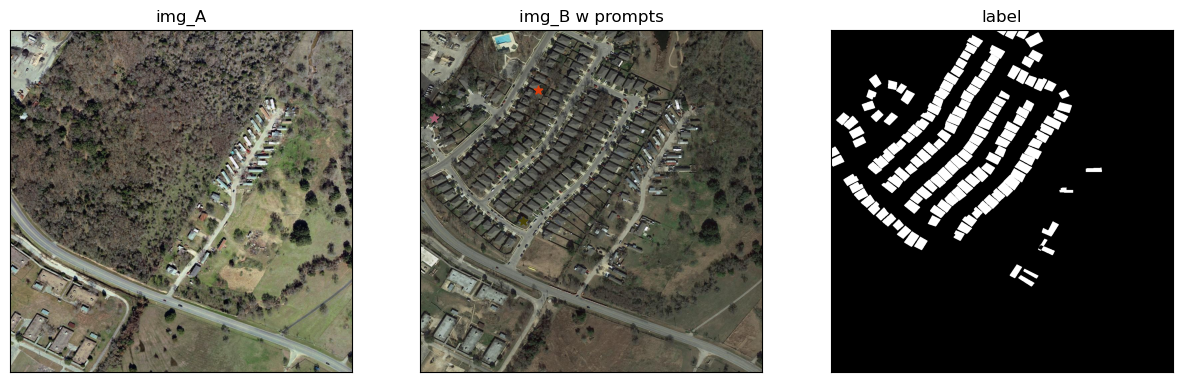

In [14]:
show_sample_from_batch(batch, idx=0)

In [21]:
fname = "test_12.png"
id_sample = ds.get_from_name(fname, return_sample=False)

if isinstance(id_sample, int): id_sample = [id_sample]
sub_ds = data.Subset(ds, id_sample)
sub_dl = data.DataLoader(sub_ds, batch_size=1, shuffle=False)
batch = next(iter(sub_dl))

[11]


In [ ]:
preds, ious = module(batch)
# B x 1 x 1024 x 1024
preds = preds.squeeze().detach().cpu()

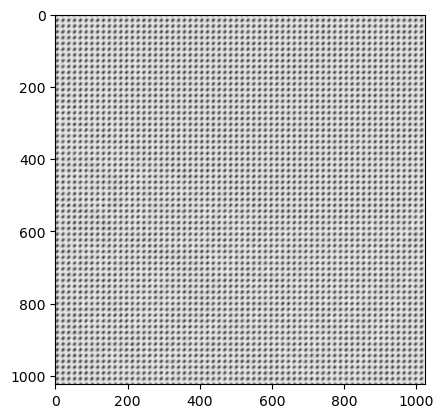

In [30]:
plt.imshow(preds.detach(), cmap="Greys_r")